# Data Processing and Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [1]:
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%%time
# Load in properties data
prop = data_proc.load_properties_data("data/properties_2016.csv")
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))
prop.head()

Number of properties: 2985217
Number of property features: 57
CPU times: user 17.8 s, sys: 3.44 s, total: 21.2 s
Wall time: 21.2 s


In [3]:
%%time
# Load in training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
print("Number of transaction records: {}".format(len(train_2016)))
train_2016.head()

Number of transaction records: 90275
CPU times: user 44.7 ms, sys: 19.3 ms, total: 64 ms
Wall time: 61.6 ms


In [4]:
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)
prop.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,10754147,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,238,NaN,60378004.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,230,LCA11*,60378000.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60377032.0,51617.0,1815,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,6,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60371412.0,12447.0,1815,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,-1,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAM1,60371232.0,12447.0,1815,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN


In [5]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')

# Remove outliers from training set
threshold = 0.6
print("{} training examples in total".format(len(train_2016)))
print("{} with abs(logerror) > {}".format((abs(train_2016.logerror) > threshold).sum(), threshold))

train_2016 = train_2016[abs(train_2016.logerror) <= threshold]
print("New training set size (outliers removed): {}".format(len(train_2016)))

# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)
train_2016.head(30)

90275 training examples in total
951 with abs(logerror) > 0.6
New training set size (outliers removed): 89324
parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999888048005016
tax_parcel: 0.9999888048005016
tax_land: 0.9999888048005016
tax_property: 0.9999328288030093
region_zip: 0.999630558416551
tax_structure: 0.9959585329810577
census_2: 0.9933612466974161
finished_area_sqft_calc: 0.9928686579194841
year_built: 0.9918498947651248
bathroom_cnt_calc: 0.9873158389682504
bathroom_full_cnt: 0.9873158389682504
city_id: 0.9800053736957592
finished_area_sqft: 0.9491625990775155
lot_sqft: 0.8871188034570776
unit_cnt: 0.6452017374949621
zoning_description: 0.6446195871210425
quality_id: 0.6344655411759438
heating_id: 0.621210424969773
neighborhood_id: 0.39816846536205275
garage_cnt: 0.3331355514755273
garage_sqft: 0.3331

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983

In [6]:
# Add datetime features
logerror_year, logerror_month, logerror_quarter = data_proc.compute_datetime_aggregate_features(train_2016)
train_2016 = data_proc.add_datetime_aggregate_features(train_2016, logerror_year, logerror_month, logerror_quarter)    
train_2016.head()

,parcelid,logerror,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,logerror_year,logerror_month,logerror_quarter
0,11016594,0.0276,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,0.005,0.009,0.005
1,14366692,-0.1684,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,0.005,0.009,0.005
2,12098116,-0.0040,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,0.005,0.009,0.005
3,12643413,0.0218,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,0.005,0.009,0.005
4,14432541,-0.0050,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,0.005,0.009,0.005


In [7]:
# Prepare data for LightGBM
lgb_label = train_2016.logerror.astype(np.float32)

# Drop features that are not useful or too messy
lgb_features = data_proc.drop_features(train_2016)

print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 58


,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,logerror_year,logerror_month,logerror_quarter
0,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,0.005,0.009,0.005
1,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,0.005,0.009,0.005
2,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,0.005,0.009,0.005
3,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,0.005,0.009,0.005
4,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,0.005,0.009,0.005
5,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,0.005,0.009,0.005
6,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,230,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13,0.005,0.009,0.005
7,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,235,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13,0.005,0.009,0.005
8,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13,0.005,0.009,0.005
9,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.260010,NaN,NaN,6.059063e+13,0.005,0.009,0.005


In [8]:
# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (66993, 58)
y_train shape: (66993,)
X_val shape: (22331, 58)
y_val shape: (22331,)


In [9]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.001  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 512  # max number of leaves in one tree (default 31)
params['min_data'] = 175  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.7    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 10.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [10]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 5, 6, 16, 22, 31, 34, 40]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0569208	val's l1: 0.0580126
Training until validation scores don't improve for 20 rounds.
[2]	train's l1: 0.0569185	val's l1: 0.0580111
[3]	train's l1: 0.0569156	val's l1: 0.0580093
[4]	train's l1: 0.0569134	val's l1: 0.058008
[5]	train's l1: 0.0569111	val's l1: 0.0580065
[6]	train's l1: 0.0569085	val's l1: 0.058005
[7]	train's l1: 0.0569059	val's l1: 0.0580033
[8]	train's l1: 0.0569031	val's l1: 0.0580015
[9]	train's l1: 0.0569006	val's l1: 0.0580001
[10]	train's l1: 0.0568977	val's l1: 0.0579984
[11]	train's l1: 0.0568955	val's l1: 0.0579972
[12]	train's l1: 0.056893	val's l1: 0.0579956
[13]	train's l1: 0.0568903	val's l1: 0.0579937
[14]	train's l1: 0.0568878	val's l1: 0.0579922
[15]	train's l1: 0.0568854	val's l1: 0.0579909
[16]	train's l1: 0.0568832	val's l1: 0.0579896
[17]	train's l1: 0.0568809	val's l1: 0.057988
[18]	train's l1: 0.0568786	val's l1: 0.0579867
[19]	train's l1: 0.0568761	val's l1: 0.0579854
[20]	train's l1: 0.0568733	val's l1: 0.0579836
[21]	train'

[185]	train's l1: 0.0564984	val's l1: 0.0577683
[186]	train's l1: 0.0564966	val's l1: 0.0577672
[187]	train's l1: 0.0564946	val's l1: 0.0577661
[188]	train's l1: 0.0564925	val's l1: 0.0577648
[189]	train's l1: 0.0564906	val's l1: 0.057764
[190]	train's l1: 0.0564885	val's l1: 0.0577627
[191]	train's l1: 0.0564862	val's l1: 0.0577613
[192]	train's l1: 0.0564841	val's l1: 0.0577602
[193]	train's l1: 0.0564819	val's l1: 0.0577588
[194]	train's l1: 0.0564797	val's l1: 0.0577575
[195]	train's l1: 0.0564779	val's l1: 0.0577565
[196]	train's l1: 0.0564761	val's l1: 0.0577558
[197]	train's l1: 0.0564741	val's l1: 0.0577549
[198]	train's l1: 0.0564724	val's l1: 0.0577541
[199]	train's l1: 0.0564703	val's l1: 0.0577527
[200]	train's l1: 0.0564685	val's l1: 0.0577519
[201]	train's l1: 0.0564662	val's l1: 0.0577506
[202]	train's l1: 0.056464	val's l1: 0.0577494
[203]	train's l1: 0.056462	val's l1: 0.0577485
[204]	train's l1: 0.0564597	val's l1: 0.057747
[205]	train's l1: 0.0564578	val's l1: 0.0577

[368]	train's l1: 0.0561459	val's l1: 0.0575826
[369]	train's l1: 0.056144	val's l1: 0.0575817
[370]	train's l1: 0.0561421	val's l1: 0.0575806
[371]	train's l1: 0.0561404	val's l1: 0.0575797
[372]	train's l1: 0.0561385	val's l1: 0.0575788
[373]	train's l1: 0.0561366	val's l1: 0.0575778
[374]	train's l1: 0.0561349	val's l1: 0.0575769
[375]	train's l1: 0.056133	val's l1: 0.0575761
[376]	train's l1: 0.056131	val's l1: 0.0575752
[377]	train's l1: 0.0561294	val's l1: 0.0575746
[378]	train's l1: 0.0561277	val's l1: 0.0575739
[379]	train's l1: 0.0561258	val's l1: 0.0575732
[380]	train's l1: 0.0561239	val's l1: 0.0575722
[381]	train's l1: 0.0561223	val's l1: 0.0575716
[382]	train's l1: 0.0561204	val's l1: 0.0575711
[383]	train's l1: 0.0561185	val's l1: 0.0575702
[384]	train's l1: 0.0561168	val's l1: 0.0575693
[385]	train's l1: 0.056115	val's l1: 0.0575683
[386]	train's l1: 0.0561132	val's l1: 0.0575674
[387]	train's l1: 0.0561116	val's l1: 0.0575667
[388]	train's l1: 0.0561096	val's l1: 0.0575

[543]	train's l1: 0.055851	val's l1: 0.0574498
[544]	train's l1: 0.0558496	val's l1: 0.0574493
[545]	train's l1: 0.0558482	val's l1: 0.0574487
[546]	train's l1: 0.0558468	val's l1: 0.0574481
[547]	train's l1: 0.055845	val's l1: 0.0574475
[548]	train's l1: 0.0558436	val's l1: 0.0574471
[549]	train's l1: 0.0558421	val's l1: 0.0574469
[550]	train's l1: 0.0558406	val's l1: 0.0574462
[551]	train's l1: 0.0558391	val's l1: 0.0574456
[552]	train's l1: 0.0558376	val's l1: 0.0574451
[553]	train's l1: 0.0558359	val's l1: 0.0574445
[554]	train's l1: 0.0558343	val's l1: 0.0574439
[555]	train's l1: 0.0558327	val's l1: 0.0574434
[556]	train's l1: 0.0558312	val's l1: 0.057443
[557]	train's l1: 0.0558299	val's l1: 0.0574426
[558]	train's l1: 0.0558283	val's l1: 0.0574419
[559]	train's l1: 0.0558267	val's l1: 0.0574414
[560]	train's l1: 0.0558253	val's l1: 0.057441
[561]	train's l1: 0.055824	val's l1: 0.0574405
[562]	train's l1: 0.0558224	val's l1: 0.0574398
[563]	train's l1: 0.0558209	val's l1: 0.05743

[717]	train's l1: 0.0555994	val's l1: 0.0573635
[718]	train's l1: 0.055598	val's l1: 0.057363
[719]	train's l1: 0.0555965	val's l1: 0.0573627
[720]	train's l1: 0.0555952	val's l1: 0.0573625
[721]	train's l1: 0.0555939	val's l1: 0.0573621
[722]	train's l1: 0.0555926	val's l1: 0.0573616
[723]	train's l1: 0.055591	val's l1: 0.0573611
[724]	train's l1: 0.0555896	val's l1: 0.0573606
[725]	train's l1: 0.0555884	val's l1: 0.0573603
[726]	train's l1: 0.0555871	val's l1: 0.0573599
[727]	train's l1: 0.0555856	val's l1: 0.0573597
[728]	train's l1: 0.0555843	val's l1: 0.0573594
[729]	train's l1: 0.055583	val's l1: 0.0573591
[730]	train's l1: 0.0555818	val's l1: 0.0573589
[731]	train's l1: 0.0555804	val's l1: 0.0573583
[732]	train's l1: 0.0555791	val's l1: 0.057358
[733]	train's l1: 0.0555777	val's l1: 0.0573576
[734]	train's l1: 0.0555763	val's l1: 0.0573572
[735]	train's l1: 0.0555749	val's l1: 0.0573568
[736]	train's l1: 0.0555737	val's l1: 0.0573567
[737]	train's l1: 0.0555725	val's l1: 0.05735

[889]	train's l1: 0.0553825	val's l1: 0.0573008
[890]	train's l1: 0.0553812	val's l1: 0.0573004
[891]	train's l1: 0.05538	val's l1: 0.0572999
[892]	train's l1: 0.0553788	val's l1: 0.0572996
[893]	train's l1: 0.0553776	val's l1: 0.0572993
[894]	train's l1: 0.0553764	val's l1: 0.0572988
[895]	train's l1: 0.0553753	val's l1: 0.0572985
[896]	train's l1: 0.055374	val's l1: 0.057298
[897]	train's l1: 0.0553729	val's l1: 0.0572977
[898]	train's l1: 0.0553717	val's l1: 0.0572974
[899]	train's l1: 0.0553705	val's l1: 0.057297
[900]	train's l1: 0.0553693	val's l1: 0.0572968
[901]	train's l1: 0.0553679	val's l1: 0.0572964
[902]	train's l1: 0.0553667	val's l1: 0.0572961
[903]	train's l1: 0.0553655	val's l1: 0.0572959
[904]	train's l1: 0.0553643	val's l1: 0.0572958
[905]	train's l1: 0.055363	val's l1: 0.0572955
[906]	train's l1: 0.0553617	val's l1: 0.0572951
[907]	train's l1: 0.0553605	val's l1: 0.0572949
[908]	train's l1: 0.0553591	val's l1: 0.0572945
[909]	train's l1: 0.0553579	val's l1: 0.057294

[1072]	train's l1: 0.055174	val's l1: 0.0572562
[1073]	train's l1: 0.055173	val's l1: 0.057256
[1074]	train's l1: 0.0551719	val's l1: 0.0572559
[1075]	train's l1: 0.0551708	val's l1: 0.0572556
[1076]	train's l1: 0.0551698	val's l1: 0.0572554
[1077]	train's l1: 0.0551687	val's l1: 0.0572552
[1078]	train's l1: 0.0551676	val's l1: 0.057255
[1079]	train's l1: 0.0551666	val's l1: 0.0572546
[1080]	train's l1: 0.0551655	val's l1: 0.0572545
[1081]	train's l1: 0.0551644	val's l1: 0.0572544
[1082]	train's l1: 0.0551632	val's l1: 0.0572541
[1083]	train's l1: 0.0551623	val's l1: 0.0572537
[1084]	train's l1: 0.0551612	val's l1: 0.0572535
[1085]	train's l1: 0.0551602	val's l1: 0.0572532
[1086]	train's l1: 0.0551589	val's l1: 0.0572531
[1087]	train's l1: 0.0551579	val's l1: 0.057253
[1088]	train's l1: 0.0551567	val's l1: 0.0572527
[1089]	train's l1: 0.0551557	val's l1: 0.0572524
[1090]	train's l1: 0.0551545	val's l1: 0.0572521
[1091]	train's l1: 0.0551535	val's l1: 0.057252
[1092]	train's l1: 0.05515

[1248]	train's l1: 0.0549918	val's l1: 0.0572278
[1249]	train's l1: 0.0549908	val's l1: 0.0572276
[1250]	train's l1: 0.0549898	val's l1: 0.0572276
[1251]	train's l1: 0.0549888	val's l1: 0.0572274
[1252]	train's l1: 0.0549877	val's l1: 0.0572273
[1253]	train's l1: 0.0549867	val's l1: 0.057227
[1254]	train's l1: 0.0549857	val's l1: 0.0572271
[1255]	train's l1: 0.0549847	val's l1: 0.0572269
[1256]	train's l1: 0.0549837	val's l1: 0.057227
[1257]	train's l1: 0.0549826	val's l1: 0.0572269
[1258]	train's l1: 0.0549816	val's l1: 0.057227
[1259]	train's l1: 0.0549806	val's l1: 0.0572267
[1260]	train's l1: 0.0549797	val's l1: 0.0572267
[1261]	train's l1: 0.0549787	val's l1: 0.0572266
[1262]	train's l1: 0.0549778	val's l1: 0.0572265
[1263]	train's l1: 0.0549768	val's l1: 0.0572265
[1264]	train's l1: 0.0549757	val's l1: 0.0572265
[1265]	train's l1: 0.0549747	val's l1: 0.0572265
[1266]	train's l1: 0.0549737	val's l1: 0.0572263
[1267]	train's l1: 0.0549728	val's l1: 0.0572264
[1268]	train's l1: 0.05

[1419]	train's l1: 0.0548237	val's l1: 0.0572056
[1420]	train's l1: 0.0548228	val's l1: 0.0572054
[1421]	train's l1: 0.054822	val's l1: 0.0572056
[1422]	train's l1: 0.054821	val's l1: 0.0572056
[1423]	train's l1: 0.0548202	val's l1: 0.0572054
[1424]	train's l1: 0.0548192	val's l1: 0.0572055
[1425]	train's l1: 0.0548183	val's l1: 0.0572054
[1426]	train's l1: 0.0548173	val's l1: 0.0572052
[1427]	train's l1: 0.0548164	val's l1: 0.0572052
[1428]	train's l1: 0.0548156	val's l1: 0.0572051
[1429]	train's l1: 0.0548146	val's l1: 0.0572051
[1430]	train's l1: 0.0548138	val's l1: 0.0572049
[1431]	train's l1: 0.0548128	val's l1: 0.0572051
[1432]	train's l1: 0.0548119	val's l1: 0.0572051
[1433]	train's l1: 0.0548109	val's l1: 0.057205
[1434]	train's l1: 0.0548099	val's l1: 0.0572048
[1435]	train's l1: 0.054809	val's l1: 0.0572047
[1436]	train's l1: 0.054808	val's l1: 0.0572046
[1437]	train's l1: 0.054807	val's l1: 0.0572042
[1438]	train's l1: 0.0548062	val's l1: 0.0572042
[1439]	train's l1: 0.05480

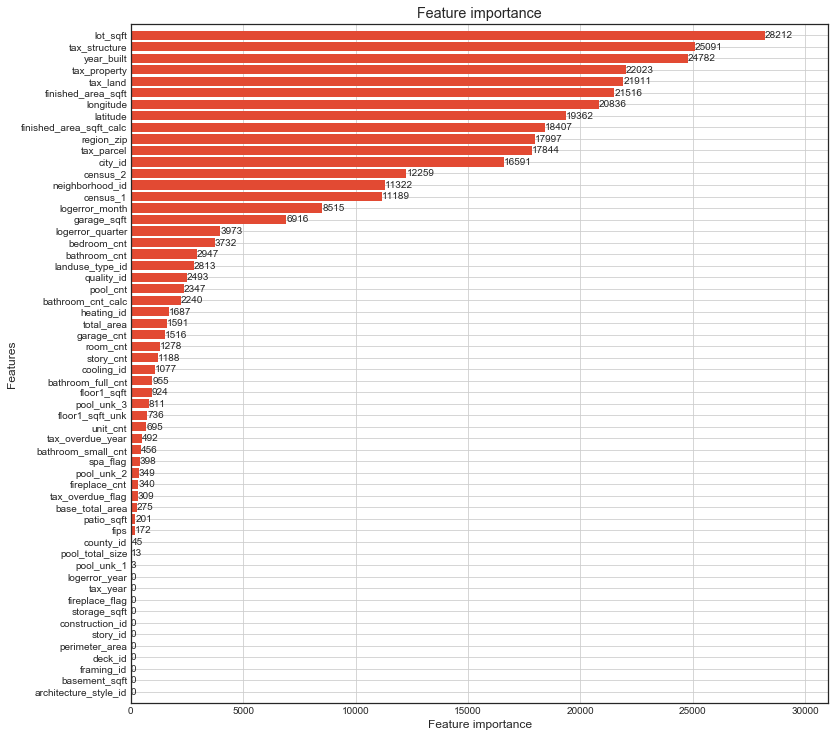

In [11]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [12]:
%%time
def predict_and_export(clf, prop, file_name):
    # Construct DataFrame for prediction results
    submission = pd.DataFrame()
    submission['ParcelId'] = prop.parcelid
    
    # Construct features and make prediction
    test_features = data_proc.drop_features(prop)
    
    test_dates = ['2016-10-01']
    test_columns = ['201610']
    for d, c in zip(test_dates, test_columns):
        print("Start predicting for {}".format(c))

        test_features['transactiondate'] = d
        test_features = data_proc.add_datetime_aggregate_features(test_features,
                                                                  logerror_year, logerror_month, logerror_quarter)

        pred_test = clf.predict(test_features)
        pred_test = [float(format(x, '.4f')) for x in pred_test]
        submission[c] = pred_test
        
        print("Finished predicting for {}".format(c))
    
    submission['201611'] = submission['201610']
    submission['201612'] = submission['201610']
    submission['201710'] = submission['201610']
    submission['201711'] = submission['201610']
    submission['201712'] = submission['201610']
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission  # Return the results just in case we want to analyze or sanity check it

submission = predict_and_export(clf, prop, 'data/test.csv')

Start predicting for 201610
Finished predicting for 201610
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0154 -0.0154 -0.0154 -0.0154 -0.0154 -0.0154
1  10759547 -0.0127 -0.0127 -0.0127 -0.0127 -0.0127 -0.0127
2  10843547  0.0076  0.0076  0.0076  0.0076  0.0076  0.0076
3  10859147  0.0145  0.0145  0.0145  0.0145  0.0145  0.0145
4  10879947 -0.0078 -0.0078 -0.0078 -0.0078 -0.0078 -0.0078
CPU times: user 30min 11s, sys: 17.3 s, total: 30min 28s
Wall time: 8min 7s


In [ ]:
# Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('cat_smooth', [5.0, 10.0, 15.0, 20.0])